In [1]:
import struct
from pynq import Overlay
from pynq import DefaultIP
from pynq.lib.video import *

import numpy
import time
import PIL.Image
import asyncio

In [2]:
class Mandelbrot(DefaultIP):
    def __init__(self, description):
        super().__init__(description=description)
        # Set up resolution
        self.write(0x10,1920)
        self.write(0x18,1080)
        # Enable interrupts for ap_done
        self.write(0x04,1)
        self.write(0x08,1)
        # Setup default config
        self.config(3.5, 2.0, -2.5, 1.0, 100)
        
    bindto = ['xilinx.com:hls:mandelbrot:1.0']
    
    def config(self, plot_width, plot_height, x_min, y_max, iterations):
        self.write(0x20,struct.pack('f', plot_width))
        self.write(0x28,struct.pack('f', plot_height))
        self.write(0x30,struct.pack('f', x_min))
        self.write(0x38,struct.pack('f', y_max))
        self.write(0x40,iterations)
    
    def set_plot_width(self, plot_width):
        self.write(0x20,struct.pack('f', plot_width))
    
    def set_plot_height(self, plot_height):
        self.write(0x28,struct.pack('f', plot_height))
    
    def set_x_min(self, x_min):
        self.write(0x30,struct.pack('f', x_min))
    
    def set_y_max(self, y_max):
        self.write(0x38,struct.pack('f', y_max))
    
    def set_iterations(self, iterations):
        self.write(0x40,iterations)
    
    def render(self):
        # Start IP
        self.write(0x00,1)
        # Wait for interrupt
        loop = asyncio.get_event_loop()
        while(self.read(0x0c) & 0x1 == 0):
            loop.run_until_complete(asyncio.ensure_future(self.interrupt.wait()))
        # Clear interrupt
        self.write(0x0c, 0x1)
        self.interrupt.event.clear()
        # Display output
        activeframe = vdma.readchannel.activeframe
        frame = vdma.readchannel._frames[activeframe]
        return PIL.Image.fromarray(frame)
    
    def timed_render(self):
        start = time.time()
        render = self.render()
        end = time.time()
        print("Render took:", end - start, "s")
        return render
        
        

In [3]:
class AxiVDMA_Custom(pynq.lib.video.dma.AxiVDMA):
    def __init__(self, description):
        super().__init__(description=description, framecount=2)
        
    bindto = ['xilinx.com:ip:axi_vdma:6.3']

In [5]:
overlay = Overlay('/home/xilinx/pynq/overlays/personal/Mandelbrot/Mandelbrot.bit')
mandelbrot = overlay.video.mandelbrot
vdma = overlay.video.axi_vdma
hdmi_out = overlay.video.hdmi_out

hdmi_out._vdma = vdma #Find out where is this coming from, possibly the class override?

vdma.readchannel.mode = common.VideoMode(1920, 1080, 32)
hdmi_out.configure(common.VideoMode(1920, 1080, 32))
vdma.readchannel.start()
hdmi_out.start()
vdma.readchannel.tie(vdma.writechannel)

In [6]:
mandelbrot.config(0.000014, 0.000008, -1.1616267, 0.29369628, 1000)

Render took: 0.9236187934875488 s


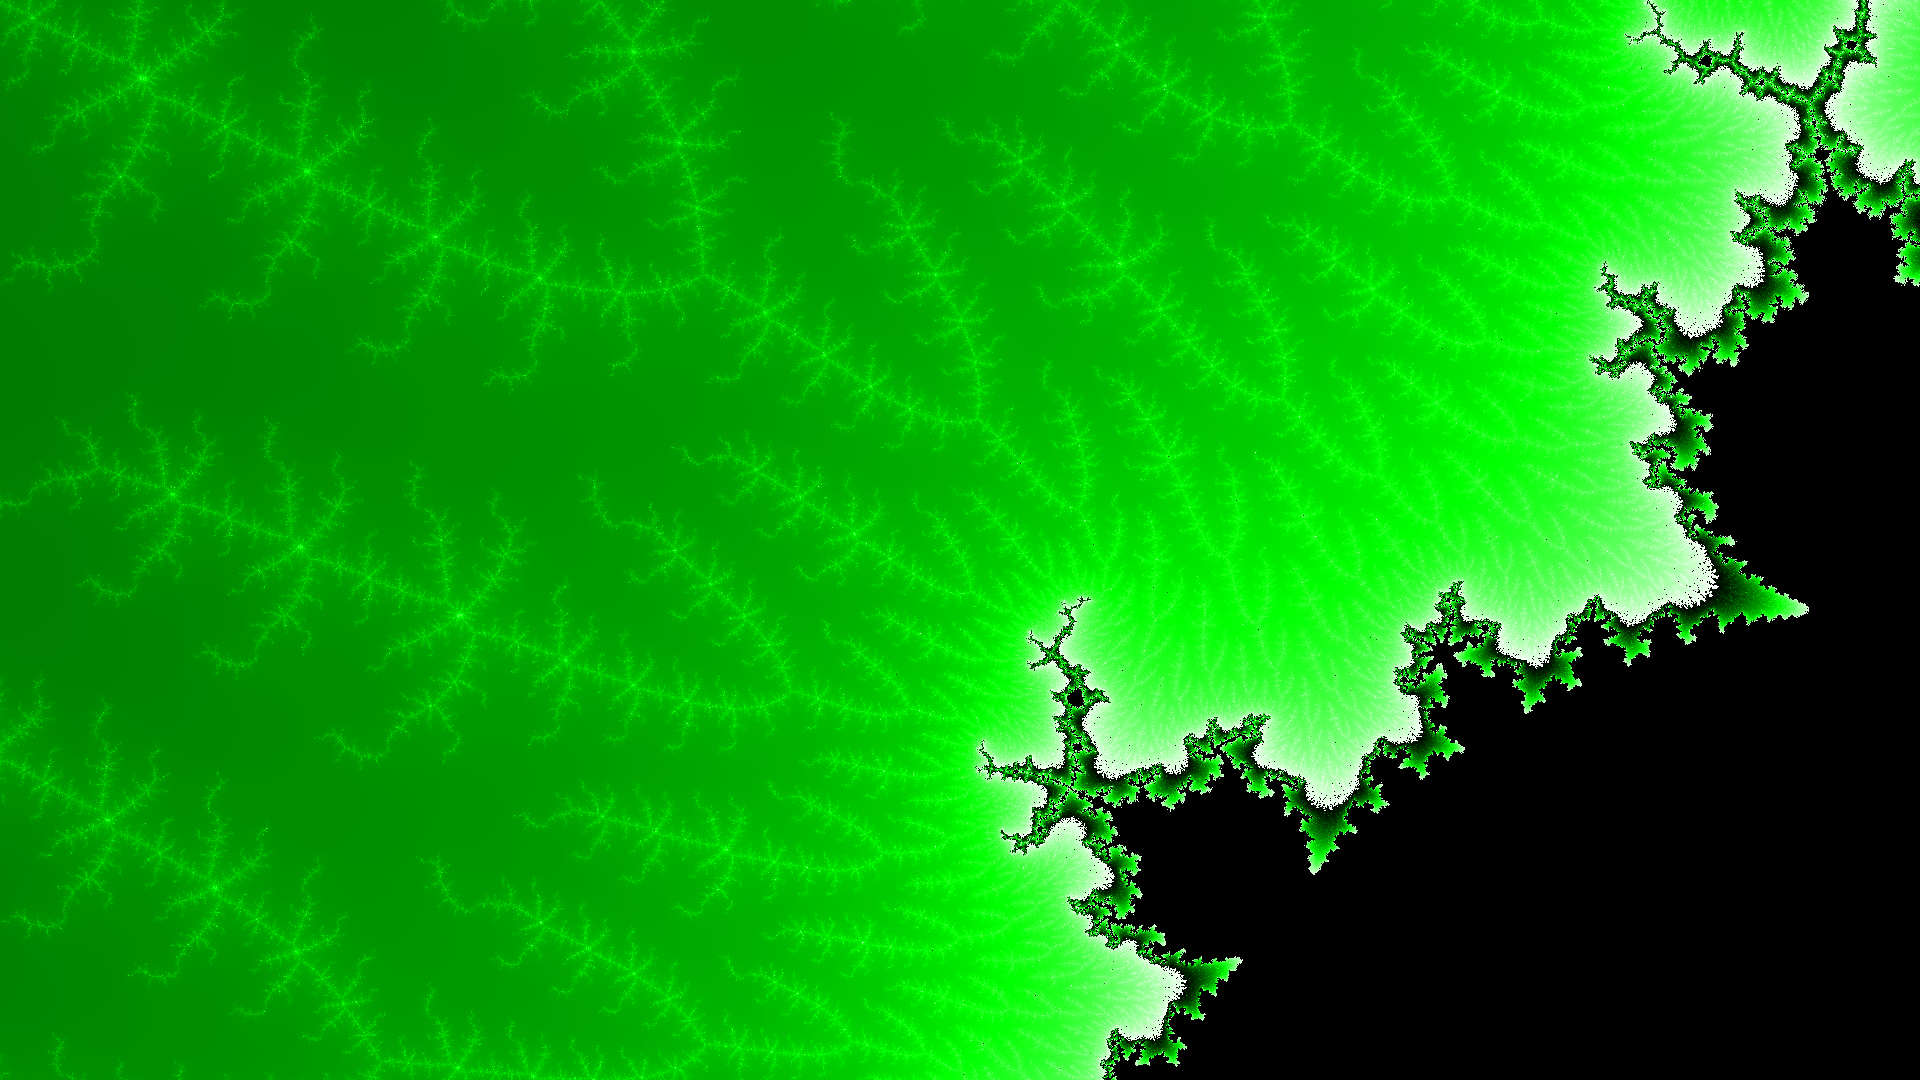

In [8]:
mandelbrot.timed_render()

In [15]:
frame = vdma.readchannel._frames[0]

In [29]:
activeframe = vdma.readchannel.activeframe
frame = vdma.readchannel._frames[activeframe]

In [10]:
i = 1400.0
j = 800.0

for _ in range(100):
    i = i / 1.5
    j = j / 1.5
    mandelbrot.config(i, j, -1.1616267, 0.29369628, 1000)
    mandelbrot.write(0x00,1)
    # Wait for interrupt
    loop = asyncio.get_event_loop()
    while(mandelbrot.read(0x0c) & 0x1 == 0):
        loop.run_until_complete(asyncio.ensure_future(mandelbrot.interrupt.wait()))
    # Clear interrupt
    mandelbrot.write(0x0c, 0x1)
    mandelbrot.interrupt.event.clear()